# SETUP

In [ ]:
import torch
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from models.decoder import Decoder
from utils.load_data import load_dataset
from config import DATA_PATH
import tensorflow as tf
from utils.fNN_layers import *
from utils.load_data import extract_target_properties
from utils.mathops import dyad
from functools import partial
from itertools import permutations, product

# === set seed for reproducibility ===
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)  # optional: if using CUDA

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# === specify trial number ===
trial = 2
trial_dir = f"checkpoints/trial_{trial}"
decoder_path = os.path.join(trial_dir, f"decoder_ckpt_{trial}.pt")
config_path = os.path.join(trial_dir, f"config_{trial}.txt")

# === load config from file ===
with open(config_path, "r") as f:
    lines = f.readlines()
config_dict = {line.split(":")[0].strip(): eval(line.split(":")[1].strip()) for line in lines}

# === extract config values ===
S_DIM = config_dict["S_DIM"]
P_DIM = config_dict["P_DIM"]
LATENT_DIM = config_dict["LATENT_DIM"]
DECODER_HIDDEN_DIMS = config_dict["DECODER_HIDDEN_DIMS"]

# === initialize decoder ===
decoder = Decoder(S_DIM, P_DIM, LATENT_DIM, DECODER_HIDDEN_DIMS).to(device)
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()

print("\n✅ Loaded decoder from trial", trial)
for k, v in config_dict.items():
    print(f"{k}: {v}")



✅ Loaded decoder from trial 1
S_DIM: 4
P_DIM: 9
LATENT_DIM: 3
ENCODER_HIDDEN_DIMS: [128, 64, 32]
DECODER_HIDDEN_DIMS: [128, 64, 32]
BATCH_SIZE: 64
LEARNING_RATE: 0.001
NUM_EPOCHS: 100
BETA: 1.0


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_56306/2672999631.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(decoder_p

# SAMPLE S-HAT

In [72]:
# === sampling function ===
def get_S_hats(P_val, num_samples=1000):
    P_tensor = P_val.repeat(num_samples, 1).to(device)
    z_samples = torch.randn((num_samples, LATENT_DIM)).to(device)
    with torch.no_grad():
        S_hats = decoder(z_samples, P_tensor)
    return S_hats.cpu().numpy()

# === peak extraction ===
def get_S_hat_peaks(S_hats, bandwidth=5.0):
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(S_hats)
    return ms.cluster_centers_

In [73]:
# === load data ===
P_all, S_all = load_dataset(DATA_PATH)
P_val = P_all[0].unsqueeze(0).to(device)   # (1, P_dim)
S_true = S_all[0].cpu().numpy()            # (S_dim,)
P_unique = torch.unique(P_all, dim=0)
print(f"{len(P_unique)} unique P vectors out of {len(P_all)} total rows.")

# === run sampling and peak extraction ===
S_hats = get_S_hats(P_val, num_samples=1000)
S_hat_peaks = get_S_hat_peaks(S_hats, bandwidth=20.0) # choose 20.0 for consistency but see other options below

# === print number of peaks for different bandwidths ===
print("\nBandwidth sensitivity:")
for bw in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
    peaks = get_S_hat_peaks(S_hats, bandwidth=bw)
    print(f"Bandwidth {bw:.1f}: Found {len(peaks)} peak(s)")

21000 unique P vectors out of 21000 total rows.

Bandwidth sensitivity:
Bandwidth 0.1: Found 969 peak(s)
Bandwidth 0.5: Found 835 peak(s)
Bandwidth 1.0: Found 722 peak(s)
Bandwidth 2.0: Found 558 peak(s)
Bandwidth 5.0: Found 231 peak(s)
Bandwidth 10.0: Found 67 peak(s)
Bandwidth 20.0: Found 7 peak(s)


# PCA PROJECTION

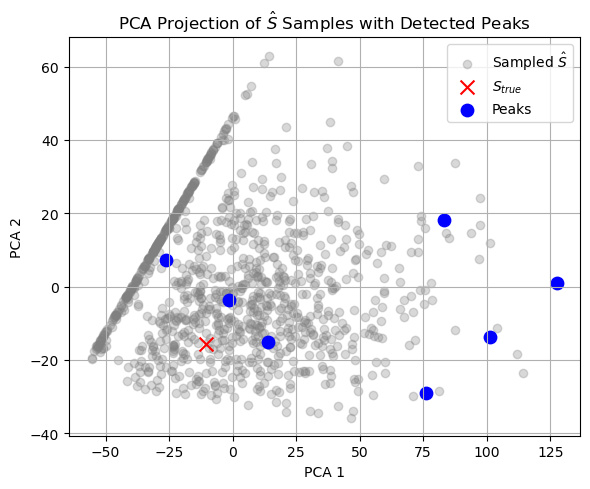

In [74]:
# === pca projection of S_hats, S_true, and peaks ===
pca = PCA(n_components=2)
S_pca = pca.fit_transform(S_hats)
S_true_pca = pca.transform(S_true.reshape(1, -1))
S_peaks_pca = pca.transform(S_hat_peaks)

plt.figure(figsize=(6, 5))
plt.scatter(S_pca[:, 0], S_pca[:, 1], alpha=0.3, label=r"Sampled $\hat{S}$", color='gray')
plt.scatter(S_true_pca[0, 0], S_true_pca[0, 1], color='red', marker='x', s=100, label=r"$S_{true}$")
plt.scatter(S_peaks_pca[:, 0], S_peaks_pca[:, 1], color='blue', marker='o', s=80, label="Peaks")
plt.title(r"PCA Projection of $\hat{S}$ Samples with Detected Peaks")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LOAD MAX'S FNN MODEL

In [77]:
# === load max's fNN model ===
custom_objects = {
    'PermutationEquivariantLayer': PermutationEquivariantLayer,
    'DoubleContractionLayer': DoubleContractionLayer,
    'EnforceIsotropyLayer': EnforceIsotropyLayer,
    'NormalizationLayer': NormalizationLayer
}

fNN = tf.keras.models.load_model('utils/max_fNN.h5', custom_objects=custom_objects)  # adjust path if needed
print("✅ Loaded Max's forward model")

# === evaluate each S_hat_peak ===
P_target = P_val.cpu().numpy().flatten()  # shape: (9,)

for i, S_peak in enumerate(S_hat_peaks):
    S_peak_tf = np.expand_dims(S_peak, axis=(0, 1))  # shape: (1, 1, 4)
    # output: shape (1, 1, 3, 3, 3, 3)
    C_pred = fNN(S_peak_tf).numpy()

    # reshape to (1, 3, 3, 3, 3)
    C_pred = C_pred.reshape(1, 3, 3, 3, 3)

    # extract 9 elastic constants → shape (1, 9)
    P_pred = extract_target_properties(C_pred)[0]  # remove batch dim

    error = np.linalg.norm(P_pred - P_target)
    # print(f"Peak {i}: ||P_pred - P_true|| = {error:.4f}")
    # print("  P_pred:", P_pred.round(3))
    # print("  P_true:", P_target.round(3))

✅ Loaded Max's forward model


In [78]:
def plot_all_P_preds_vs_true(P_preds, P_true):
    """
    Plots all P_pred vs P_true bar plots in a grid layout.

    Args:
        P_preds (list of np.ndarray): List of predicted property vectors (each shape (9,))
        P_true (np.ndarray): Ground-truth property vector (shape (9,))
    """
    labels = [
        "C1111", "C1122", "C1133", "C2222", "C2233", "C3333",
        "C1212", "C1313", "C2323"
    ]
    num_peaks = len(P_preds)
    cols = 3
    rows = (num_peaks + cols - 1) // cols  # ceiling division
    width = 0.35
    x = np.arange(len(labels))

    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axs = axs.flatten()

    for i in range(num_peaks):
        ax = axs[i]
        ax.bar(x - width/2, P_true, width, label='True P', color='lightcoral')
        ax.bar(x + width/2, P_preds[i], width, label='Predicted P', color='skyblue')
        ax.set_title(f"Peak {i + 1}")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    for j in range(num_peaks, len(axs)):
        axs[j].axis('off')  # hide unused subplots

    axs[0].legend(loc='upper right')
    fig.suptitle("Elastic Components: Predicted vs True for All Peaks", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Peak   ||P_pred - P_true||    MSE (per peak) 
---------------------------------------------
0      0.4012                 0.0179         
1      0.3251                 0.0117         
2      0.3485                 0.0135         
3      0.4269                 0.0202         
4      0.4454                 0.0220         
5      0.3735                 0.0155         
6      0.4949                 0.0272         

✅ Mean MSE across all peaks: 0.0183


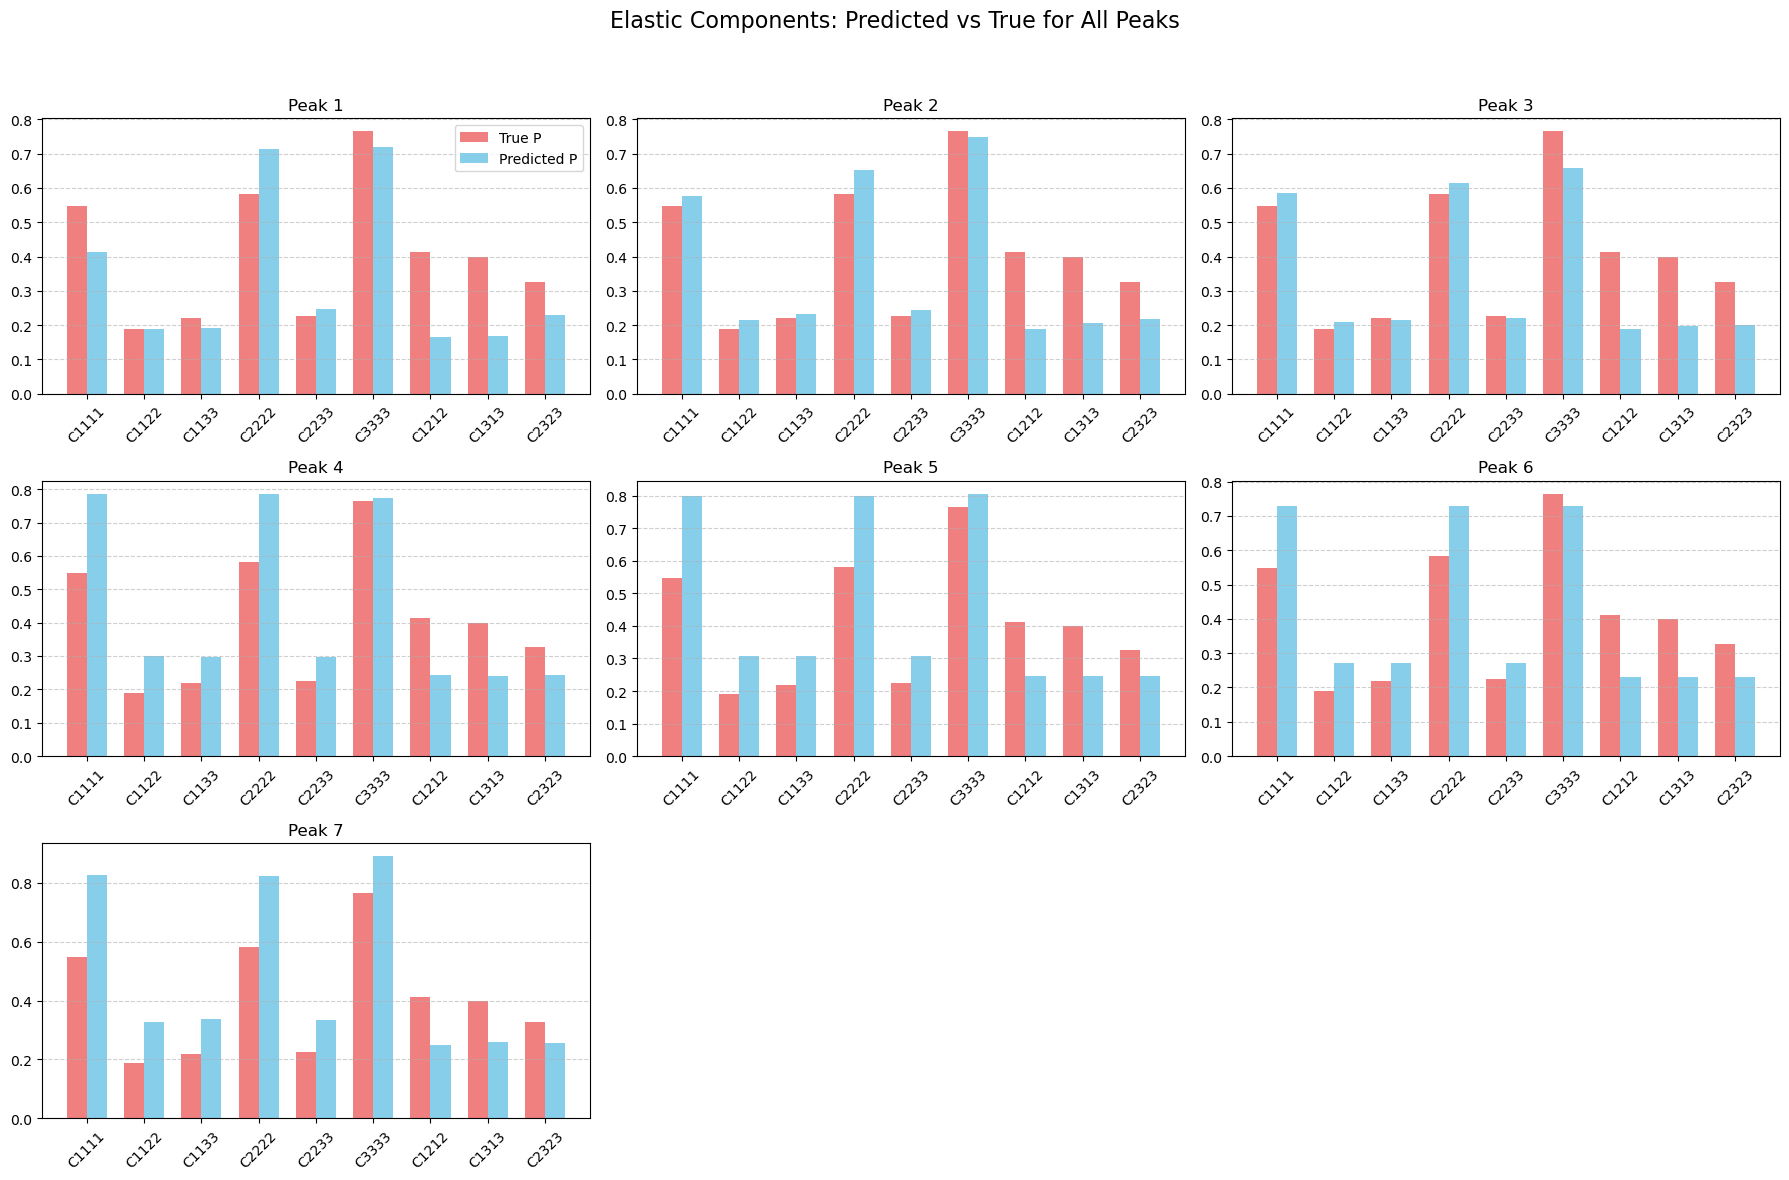

In [66]:
# === evaluate each S_hat_peak ===
P_preds = []
errors = []
mses = []

print(f"{'Peak':<6} {'||P_pred - P_true||':<22} {'MSE (per peak)':<15}")
print("-" * 45)

for i, S_peak in enumerate(S_hat_peaks):
    S_peak_tf = np.expand_dims(S_peak, axis=(0, 1))  # shape: (1, 1, 4)
    C_pred = fNN(S_peak_tf).numpy().reshape(1, 3, 3, 3, 3)
    P_pred = extract_target_properties(C_pred)[0]  # shape: (9,)
    P_preds.append(P_pred)

    # compute metrics
    l2_error = np.linalg.norm(P_pred - P_target)
    mse = np.mean((P_pred - P_target) ** 2)
    errors.append(l2_error)
    mses.append(mse)

    # print row
    print(f"{i:<6} {l2_error:<22.4f} {mse:<15.4f}")

# === summary ===
mean_mse = np.mean(mses)
print(f"\n✅ Mean MSE across all peaks: {mean_mse:.4f}")

# === plot predicted vs true ===
plot_all_P_preds_vs_true(P_preds, P_target)


In [57]:
closest_idx = np.argmin(np.linalg.norm(S_hats - S_true, axis=1))
closest_dist = np.linalg.norm(S_hats[closest_idx] - S_true)

print(f"Closest sampled S_hat is at index {closest_idx} with distance {closest_dist:.4f}")

Closest sampled S_hat is at index 156 with distance 1.7325
